In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import *

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import numpy as np
from matplotlib import pyplot as plt

from memnets.utils import set_random_seed
from memnets.processing.dataprocessing import Preprocessing
from memnets.gme.model import MEMNet, MEMEstimator,MEMLayer
from memnets.utils import ContourPlot2D

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda is available')
else:
    device = torch.device('cpu')
    print('cpu')

cpu


### Hyperparameters

In [2]:
lagtimes = [1,7,8,9,10] # encoder lag times: [\delta t, n_1 \delta t, ... , n_k \delta t]
tau = lagtimes[-1] # the lag time to obtain CVs

encoder_sizes = [30,30,30,30,10,3] # the size of each layer in MEMnets encoder
train_split = 0.9 # the ratio of training dataset size to full dataset size
batch_size = 10000 # the batch size in training dataloader
lr = 1e-3 # the learning rate to training the model

decay_rate = 2e-3 # the exponential decay rate in the dynamic scheme of gamma, a smaller decay_rate promotes the model anchors slowest mode.
thres = 0.05 # the threshold (i.e., gamma-0.5) to switch gamma to 0.5.
# note that the optimal decay_rate may vary in different systems, depending on how fast the slowest modes can be anchored.
# here we adopt a relative small decay rate for our demo.

### Load data and create time-series dataset

In [3]:
### Note that this dataset is obtained from https://github.com/markovmodel/mdshare
data = []
for i in range(3):
    data.append(np.load('../data/alanine_dipeptide/cartesian_coordinates/xyz_traj%d.npy'%i))

pre = Preprocessing()
dataset = pre.create_time_series_dataset(data, lagtimes=lagtimes)

### Train MEMnets

In [4]:
set_random_seed(1)
val = int(len(dataset)*(1-train_split))
train_data, val_data = random_split(dataset, [len(dataset)-val, val])

loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = MEMLayer([30,30,30,30,10,3])
lobe = lobe.to(device=device)

In [5]:
net = MEMNet(lobe = lobe, lagtimes = lagtimes, decay_rate=decay_rate, thres=thres, learning_rate = lr, device = device)
model = net.fit(loader_train, n_epochs=100,
                    validation_loader=loader_val, progress=tqdm).fetch_model()

### Validation curves

In [6]:
validation_lm = net.validation_lm
validation_log_lambda_hat = net.validation_log_lambda_hat
validation_gamma = net.validation_gamma

Text(0, 0.5, '$\\gamma$')

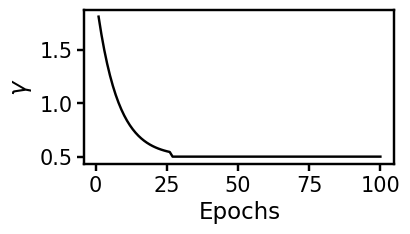

In [7]:
f,ax = plt.subplots(figsize=(4,2))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.75)
ax.plot(np.arange(1,101),validation_gamma,c='black',linewidth=1.75)

ax.tick_params(axis="x",labelsize=15,direction='out',length=5,width=1.75)
ax.tick_params(axis="y",labelsize=15,direction='out',length=5,width=1.75)
ax.set_xticks([0,25,50,75,100])
ax.set_xlabel('Epochs',fontsize=16.5)
ax.set_ylabel(r'$\gamma$',fontsize=17.5)

(0.0001, 1)

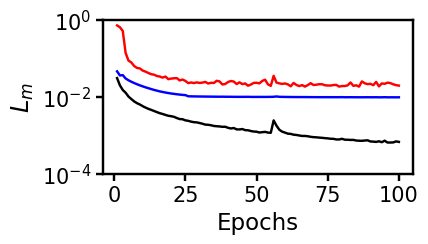

In [8]:
f,ax = plt.subplots(figsize=(4,2))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.75)
ax.semilogy(np.arange(1,101),validation_lm[:,0],c='black',linewidth=1.75)
ax.semilogy(np.arange(1,101),validation_lm[:,1],c='blue',linewidth=1.75)
ax.semilogy(np.arange(1,101),validation_lm[:,2],c='red',linewidth=1.75)

ax.tick_params(axis="x",labelsize=15,direction='out',length=5,width=1.75)
ax.tick_params(axis="y",labelsize=15,direction='out',length=5,width=1.75)
ax.set_xticks([0,25,50,75,100])
ax.set_xlabel('Epochs',fontsize=16.5)
ax.set_ylabel(r'$L_m$',fontsize=17.5)
ax.set_ylim(0.0001,1)

(0.0001, 1)

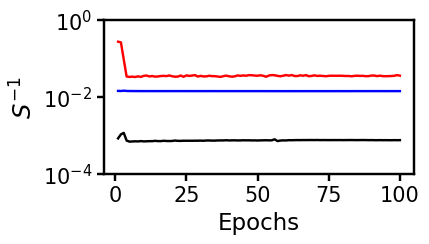

In [9]:
f,ax = plt.subplots(figsize=(4,2))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.75)
ax.semilogy(np.arange(1,101),-validation_log_lambda_hat[:,0],c='black',linewidth=1.75)
ax.semilogy(np.arange(1,101),-validation_log_lambda_hat[:,1],c='blue',linewidth=1.75)
ax.semilogy(np.arange(1,101),-validation_log_lambda_hat[:,2],c='red',linewidth=1.75)

ax.tick_params(axis="x",labelsize=15,direction='out',length=5,width=1.75)
ax.tick_params(axis="y",labelsize=15,direction='out',length=5,width=1.75)
ax.set_xticks([0,25,50,75,100])
ax.set_xlabel('Epochs',fontsize=16.5)
ax.set_ylabel(r'$S^{-1}$',fontsize=17.5)
ax.set_ylim(0.0001,1)

### MEMnets time scales

In [10]:
memnets_estimator = MEMEstimator(memnet_model=model,lagtimes=lagtimes)
time_scales = memnets_estimator.fit(data).time_scales
print(time_scales)

[1438.0984     68.46837    37.014225]


### CVs

In [11]:
cvs = model.transform(data,tau=tau)

In [13]:
dihedral = []
for i in range(3):
    dihedral.append(np.load('../data/alanine_dipeptide/dihedral_coordinates/dihedral_traj%d.npy'%i))

Text(0, 0.5, '$\\psi$')

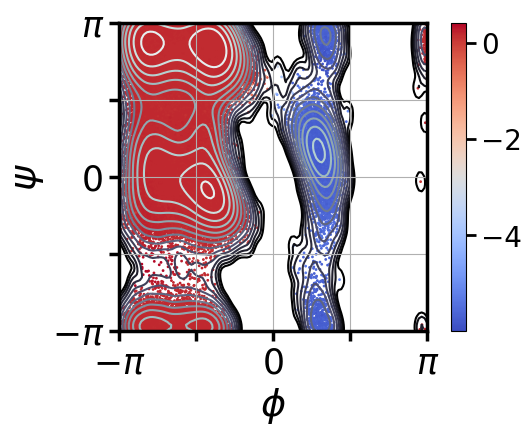

In [14]:
f, ax = plt.subplots(1,1, figsize=(6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.set_aspect('equal')
s = ax.scatter(np.concatenate(dihedral)[:,0],np.concatenate(dihedral)[:,1],c=np.concatenate(cvs)[:,0],cmap='coolwarm',s=1,alpha=1)
cb=f.colorbar(s,ax=ax) 
cb.ax.tick_params(labelsize=20,length=7.5,width=2)
c = ContourPlot2D(shade=False)
ax = c.plot(data=np.array(np.concatenate(dihedral)),ax=ax,cbar=False)
ax.tick_params(axis="both",labelsize=25,direction='out',length=7.5,width=2.5)
ax.set_ylim(-np.pi,np.pi)
ax.set_xlim(-np.pi,np.pi)
ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'$-\pi$','','0','',r'$\pi$'])
ax.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'$-\pi$','','0','',r'$\pi$'])
ax.set_xlabel(r'$\phi$',fontsize=27.5)
ax.set_ylabel(r'$\psi$',fontsize=27.5)

Text(0, 0.5, '$\\psi$')

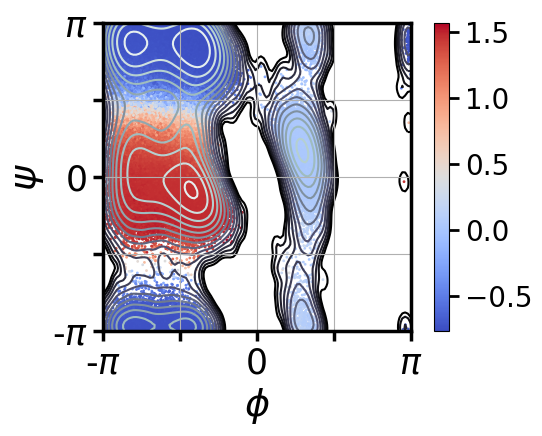

In [15]:
f, ax = plt.subplots(1,1, figsize=(6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.set_aspect('equal')
s = ax.scatter(np.concatenate(dihedral)[:,0],np.concatenate(dihedral)[:,1],c=np.concatenate(cvs)[:,1],cmap='coolwarm',s=1,alpha=1)
cb=f.colorbar(s,ax=ax) 
cb.ax.tick_params(labelsize=20,length=7.5,width=2)
c = ContourPlot2D(shade=False)
ax = c.plot(data=np.array(np.concatenate(dihedral)),ax=ax,cbar=False)
ax.tick_params(axis="both",labelsize=25,direction='out',length=7.5,width=2.5)
ax.set_ylim(-np.pi,np.pi)
ax.set_xlim(-np.pi,np.pi)
ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'-$\pi$','','0','',r'$\pi$'])
ax.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'-$\pi$','','0','',r'$\pi$'])
ax.set_xlabel(r'$\phi$',fontsize=27.5)
ax.set_ylabel(r'$\psi$',fontsize=27.5)

Text(0, 0.5, '$\\psi$')

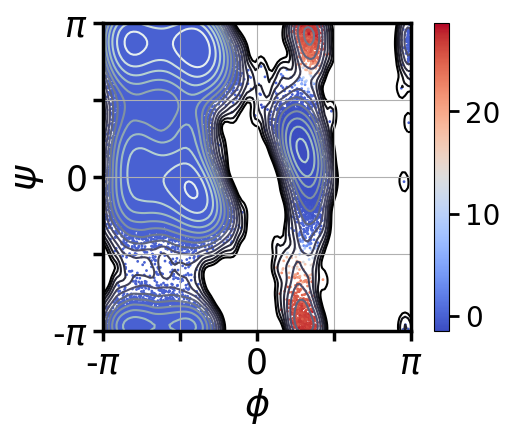

In [16]:
f, ax = plt.subplots(1,1, figsize=(6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.set_aspect('equal')
s = ax.scatter(np.concatenate(dihedral)[:,0],np.concatenate(dihedral)[:,1],c=np.concatenate(cvs)[:,2],cmap='coolwarm',s=1,alpha=1)
cb=f.colorbar(s,ax=ax) 
cb.ax.tick_params(labelsize=20,length=7.5,width=2)
c = ContourPlot2D(shade=False)
ax = c.plot(data=np.array(np.concatenate(dihedral)),ax=ax,cbar=False)
ax.tick_params(axis="both",labelsize=25,direction='out',length=7.5,width=2.5)
ax.set_ylim(-np.pi,np.pi)
ax.set_xlim(-np.pi,np.pi)
ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'-$\pi$','','0','',r'$\pi$'])
ax.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'-$\pi$','','0','',r'$\pi$'])
ax.set_xlabel(r'$\phi$',fontsize=27.5)
ax.set_ylabel(r'$\psi$',fontsize=27.5)